In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

C:\Users\ishank.aggarwal\AppData\Local\Temp\ipykernel_23892\4143437700.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
df = pd.read_csv('TATASTEEL.NS.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,8.309460,8.601414,8.202785,8.559305,4.219491,35678775
1,2000-01-04,8.427365,8.590185,8.031542,8.466666,4.173824,27698564
2,2000-01-05,8.118567,9.146021,8.118567,8.789500,4.332972,68399389
3,2000-01-06,8.924248,9.494120,8.924248,9.446396,4.656803,45604218
4,2000-01-07,9.735543,10.049955,9.336914,9.654133,4.759211,64862245


In [9]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6086,2024-05-22,175.449997,175.500000,171.500000,173.300003,173.300003,42919832
6087,2024-05-23,173.050003,175.800003,170.500000,175.500000,175.500000,49377680
6088,2024-05-24,174.949997,177.550003,174.149994,174.850006,174.850006,38674485
6089,2024-05-27,177.699997,177.699997,174.850006,175.500000,175.500000,30410585
6090,2024-05-28,175.899994,177.500000,173.449997,174.899994,174.899994,39208456


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6091 entries, 0 to 6090
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6091 non-null   object 
 1   Open       6091 non-null   float64
 2   High       6091 non-null   float64
 3   Low        6091 non-null   float64
 4   Close      6091 non-null   float64
 5   Adj Close  6091 non-null   float64
 6   Volume     6091 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 333.2+ KB


In [8]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6091.000000,6091.000000,6091.000000,6091.000000,6091.000000,6.091000e+03
mean,46.808417,47.527648,45.986326,46.724535,37.807503,7.002467e+07
std,34.111065,34.513920,33.610410,34.045161,33.667366,5.847052e+07
min,3.705570,3.910499,3.705570,3.775751,1.997227,0.000000e+00
25%,24.890244,25.283248,24.359211,24.846971,17.783267,3.336428e+07
50%,39.683289,40.391270,39.019653,39.790245,29.387579,5.356408e+07
75%,57.623894,58.440432,56.697357,57.523857,43.090733,8.632924e+07
max,177.699997,177.699997,174.850006,175.500000,175.500000,6.428460e+08


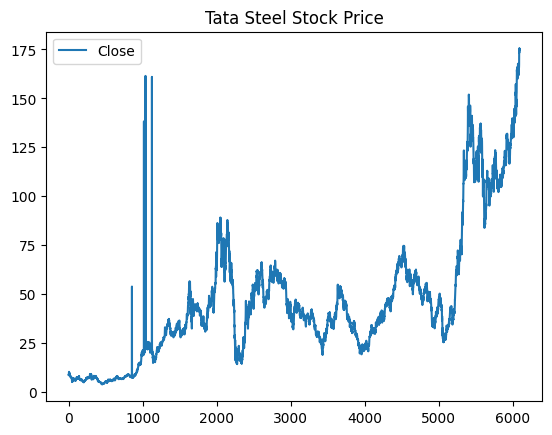

In [6]:
df[['Close']].plot()
plt.title("Tata Steel Stock Price")
plt.show()

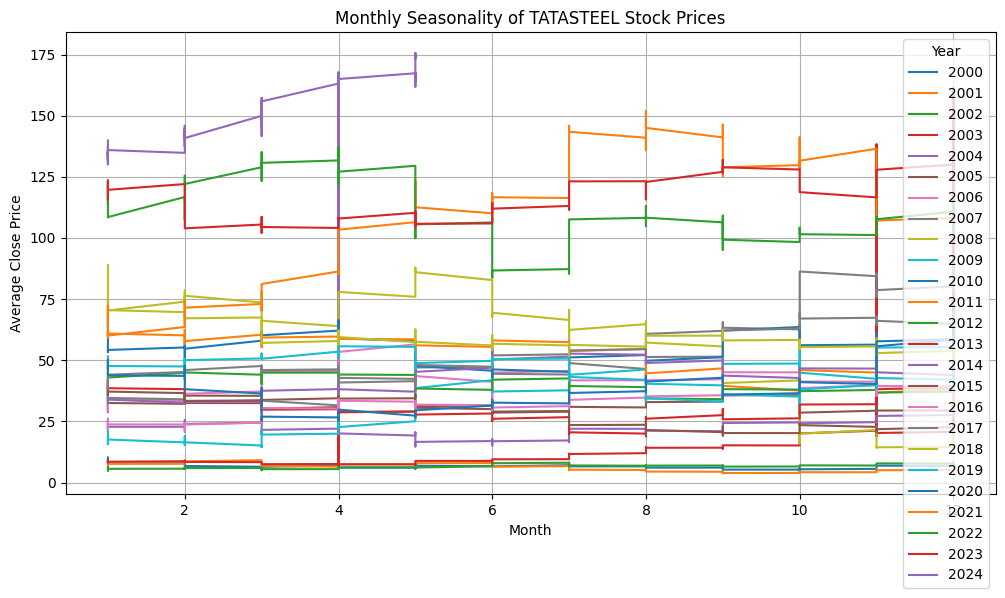

In [10]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort DataFrame by Date
df.sort_values(by='Date', inplace=True)

# Add columns for Year and Month
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Resample data to monthly frequency, calculating the mean Close price for each month
monthly_data = df.resample('M', on='Date').mean()

# Plotting seasonality
plt.figure(figsize=(12, 6))
for year in df['Year'].unique():
    yearly_data = df[df['Year'] == year]
    plt.plot(yearly_data['Month'], yearly_data['Close'], label=year)

plt.title('Monthly Seasonality of TATASTEEL Stock Prices')
plt.xlabel('Month')
plt.ylabel('Average Close Price')
plt.legend(title='Year')
plt.grid(True)

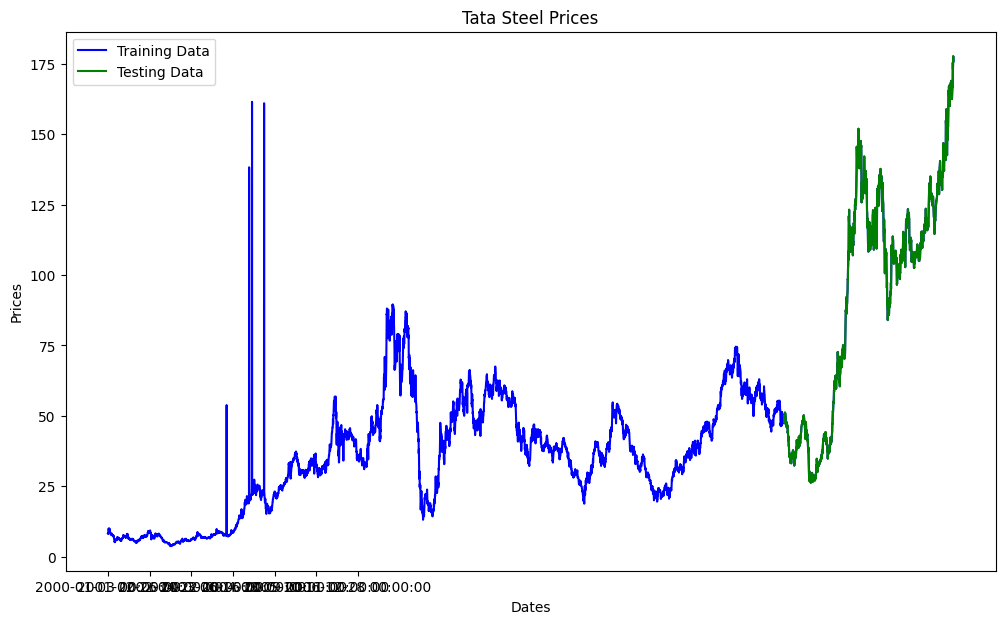

In [12]:
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
plt.figure(figsize=(12,7))
plt.title('Tata Steel Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df['Open'], 'blue', label='Training Data')
plt.plot(test_data['Open'], 'green', label='Testing Data')
plt.xticks(np.arange(0,1857, 300), df['Date'][0:1857:300])
plt.legend()

In [13]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

In [18]:
# Ensure 'Open' column is used as training and testing arrays
train_ar = train_data['Open'].values
test_ar = test_data['Open'].values

history = [x for x in train_ar]
print(type(history))
predictions = list()

for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    # Uncomment the following line to see the predicted and observed values
    # print('predicted=%f, expected=%f' % (yhat, obs))

error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)

def smape_kun(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>
Testing Mean Squared Error: 8.305
Symmetric mean absolute percentage error: 2.369


C:\Users\ishank.aggarwal\AppData\Local\Temp\ipykernel_23892\2753071142.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "green" (-> color=(0.0, 0.5019607843137255, 0.0, 1.0)). The keyword argument will take precedence.
  plt.plot(df['Open'], 'green', color='blue', label='Training Data')


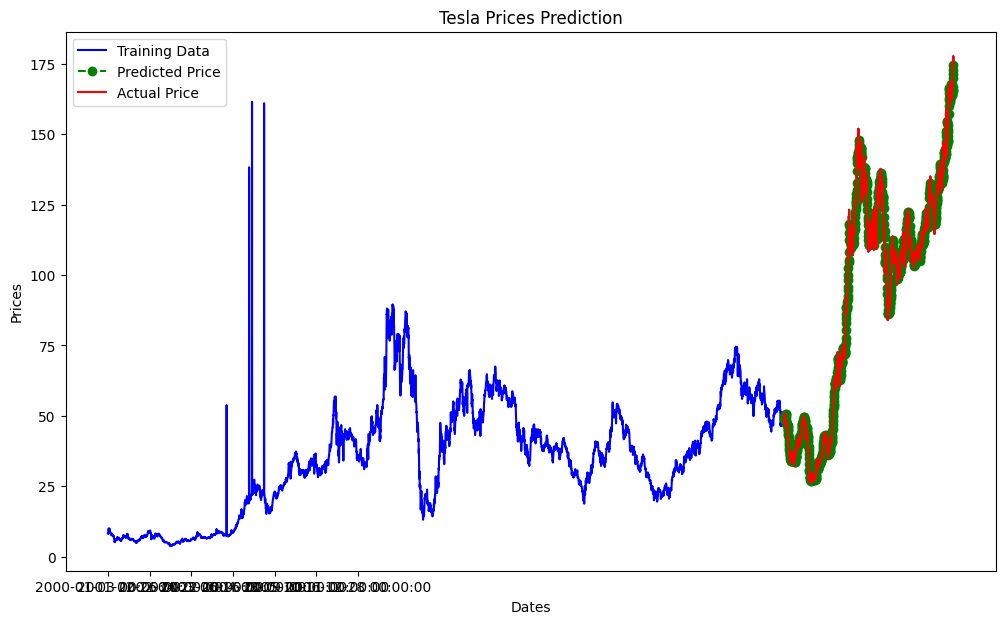

In [19]:
plt.figure(figsize=(12,7))
plt.plot(df['Open'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Actual Price')
plt.title('Tesla Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,1857, 300), df['Date'][0:1857:300])
plt.legend()

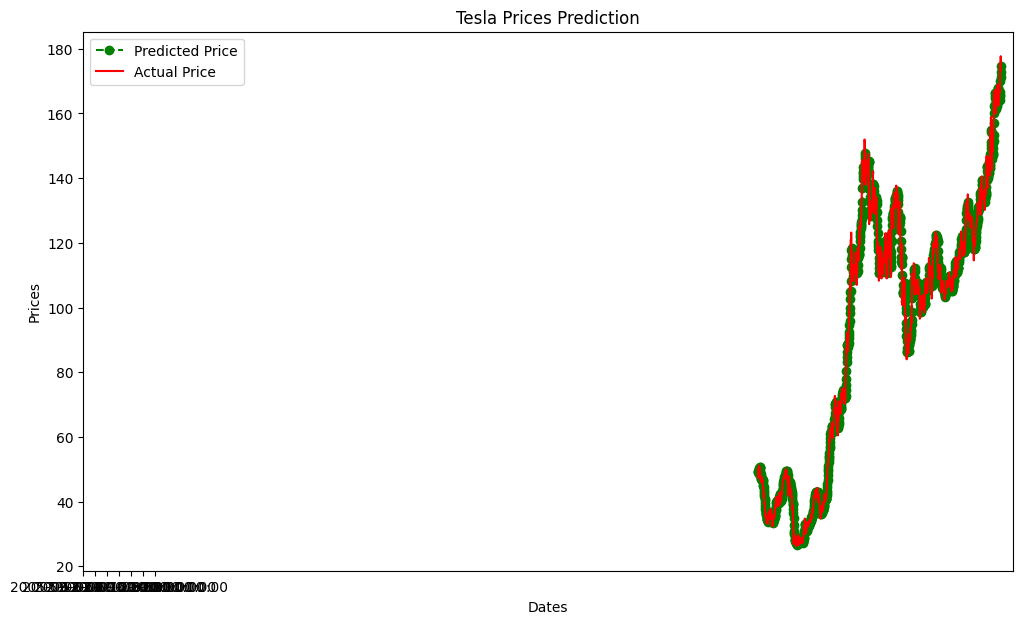

In [20]:
plt.figure(figsize=(12,7))
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Actual Price')
plt.xticks(np.arange(1486,1856, 60), df['Date'][1486:1856:60])
plt.title('Tesla Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()